# Evaluation


## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import torch.nn.functional as F
from dataset import LTTDataset

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

img_save_dir = 'graphics/'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual


args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## LD3 Best timesteps


In [ ]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

print(f"n3_params:\n{n3_params}")
print(f"n5_params:\n{n5_params}")
print(f"n7_params:\n{n7_params}")
print(f"n10_params:\n{n10_params}")

## LTT Model

In [ ]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_batch3_moreData_N5-val50-train450-r5/final_ltt_model.pt", 5
without_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_without_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
with_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_with_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
trained_on_optimal_without_dropout, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs/RandomModels/model_lr0.0001_batch5_without_dropout.pth", 5
after_ltt_change, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_After_LTT_DatasetAdjustement_batch3_N5-val50-train450-r2/final_ltt_model.pt", 5

ltt_model = LTT_model(steps=steps)
state_dict = torch.load(trained_on_optimal_without_dropout, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

In [ ]:
params_list = ltt_model.forward(torch.stack(second_outputs)) 

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [ ]:
params_list


### U-net encoding

In [ ]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0].unsqueeze(0))

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




In [ ]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

In [ ]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent.unsqueeze(0))
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



## Visualizing Good vs Bad Diffusion Processes

In [1]:
n_steps = 10

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual



args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=True) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=True, optimal_params_path=f"opt_t_final_{n_steps}")

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:

img, latent, optimal_params = train_dataset[24]
latent = latent.to(device)
optimal_params = optimal_params.to(device)


In [11]:
timestep_optimal = dis_model.convert(optimal_params.unsqueeze(0))[0]

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_optimal,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )

visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/OptimalTrajectory.png")

timestep_large = torch.tensor([80.0, 60, 40, 30, 20, 10,
        5, 1, 0.5, 0.3, 0.1],
       device='cuda:0')

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_large,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )

visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/TooLargeTrajectory.png")


timestep_small = torch.tensor([80.0, 30, 5,1, 0.1, 0.005, 0.001,
        0.0005, 0.0001, 0.00005, 0.00001],
       device='cuda:0')

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_small,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )

visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/TooSmallTrajectory.png")


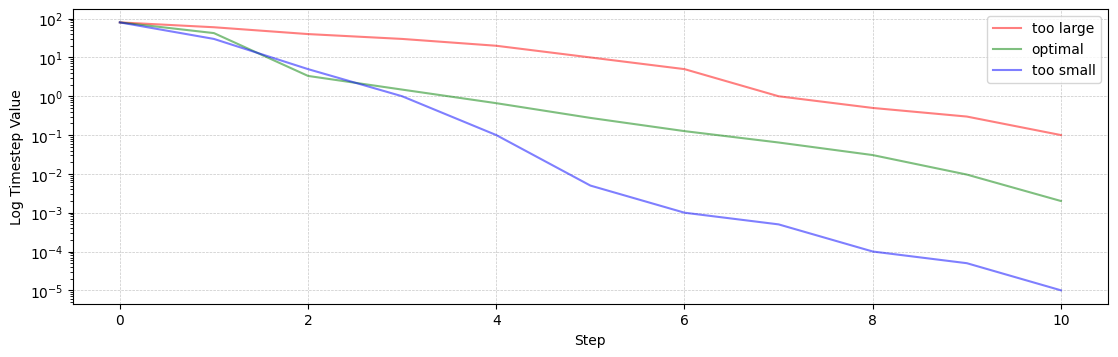

In [14]:
plt.figure(figsize=(12, 4))

plt.plot(timestep_large.flatten().detach().cpu().numpy(), label="too large", alpha=0.5, color='red')
plt.plot(timestep_optimal.flatten().detach().cpu().numpy(), label="optimal", alpha=0.5, color='green')
plt.plot(timestep_small.flatten().detach().cpu().numpy(), label="too small", alpha=0.5, color='blue')


plt.xlabel('Step')
plt.ylabel('Log Timestep Value')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join("graphics", "GoodVsBad_Trajectories.jpg"),
    format='jpg',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()

## Optimal Timesteps Per Image

In [5]:
#load from torch.save(loss_matrix, os.path.join(args.data_dir, f"loss_matrix.pt"))
optimal_dir = os.path.join(data_dir, "OldOptimSteps")


### Compare optimal params for different images

In [7]:
optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:]

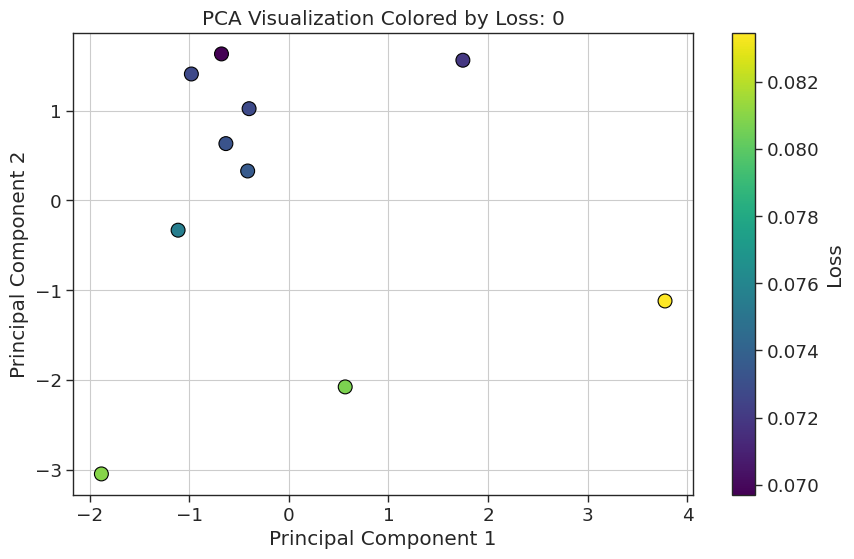

params
 [[0.15898855 0.27508447 0.06689791 0.08727948 0.12657186 0.2851777 ]
 [0.22935165 0.17737472 0.14502746 0.07310979 0.09369045 0.28144592]
 [0.09128688 0.27158314 0.12323708 0.08346662 0.11904505 0.31138128]
 [0.12033855 0.2611611  0.12721223 0.07535551 0.10478681 0.31114575]
 [0.09208058 0.26446053 0.13968274 0.0723978  0.09797411 0.3334043 ]
 [0.09908798 0.25991303 0.14389521 0.06860355 0.08801129 0.34048897]
 [0.12719595 0.28371397 0.04949946 0.06148001 0.11044621 0.36766443]
 [0.12042654 0.26357102 0.17394674 0.02792281 0.0297313  0.3844016 ]
 [0.08475728 0.33998972 0.02726892 0.03164586 0.06889394 0.44744432]
 [0.4020662  0.17225009 0.0656352  0.02160465 0.04446774 0.2939761 ]]
losses
 [0.06969571 0.07194258 0.07272594 0.07277849 0.07322695 0.07352376
 0.07551757 0.08076267 0.08095017 0.08345899]


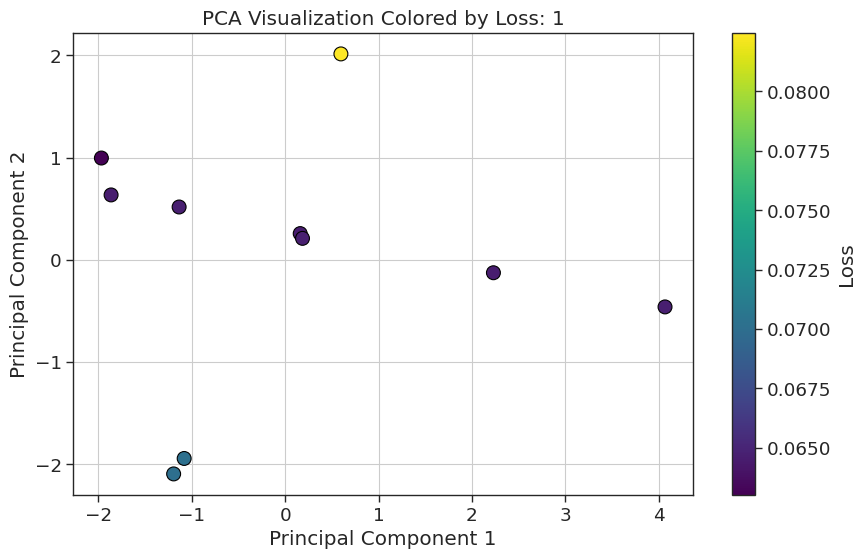

params
 [[0.06652778 0.18934311 0.11630219 0.12288577 0.08715967 0.41778147]
 [0.16496408 0.1687646  0.1304337  0.10808855 0.07664265 0.3511065 ]
 [0.06091489 0.18995664 0.14705864 0.12178459 0.08699535 0.39328983]
 [0.2723489  0.14702481 0.11412923 0.09411455 0.06663439 0.3057481 ]
 [0.16525003 0.1687522  0.13051559 0.10862729 0.07603692 0.35081798]
 [0.09814773 0.18191198 0.14080109 0.11679681 0.0832182  0.37912416]
 [0.36829412 0.12764218 0.0990373  0.08181605 0.05788147 0.26532885]
 [0.048259   0.21824501 0.21053797 0.13355415 0.06788329 0.32152057]
 [0.0538916  0.21614581 0.20918025 0.12908117 0.06776272 0.3239384 ]
 [0.11483752 0.13622913 0.247508   0.04682485 0.07532397 0.3792766 ]]
losses
 [0.06301361 0.0645799  0.06460025 0.06460202 0.06461436 0.06461923
 0.06463726 0.07007363 0.07009947 0.08246382]


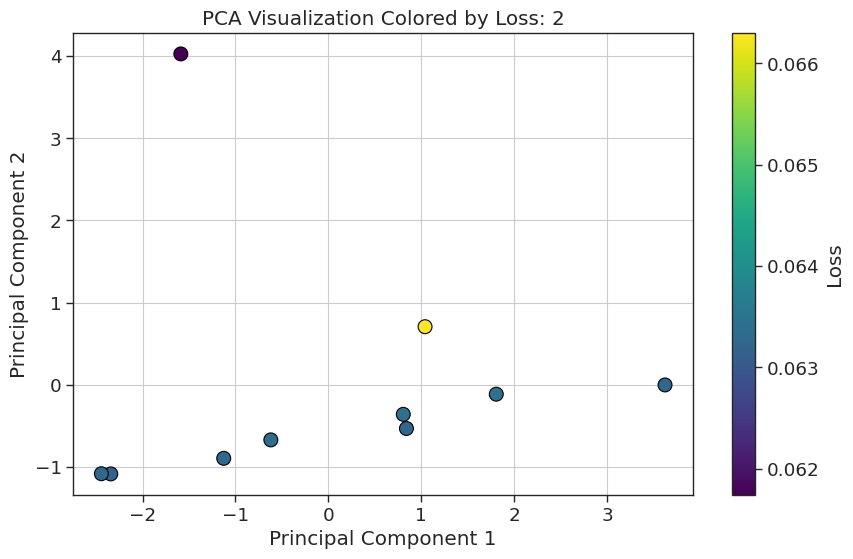

params
 [[0.10397553 0.03360744 0.30653185 0.0836305  0.12183718 0.35041755]
 [0.16265894 0.21137396 0.0923155  0.08292594 0.10936632 0.34135935]
 [0.03957773 0.24176276 0.1062265  0.09569358 0.12604855 0.3906908 ]
 [0.09782153 0.22866152 0.09839883 0.08992638 0.11852566 0.36666605]
 [0.16629612 0.21012583 0.09173562 0.08296724 0.10984243 0.33903283]
 [0.14012532 0.21752599 0.09398444 0.08625474 0.11310581 0.34900373]
 [0.12301557 0.22066781 0.09971653 0.08591002 0.1148764  0.35581368]
 [0.07280816 0.2320241  0.10741458 0.09111439 0.12361785 0.37302092]
 [0.09315208 0.22800504 0.10400227 0.08894591 0.11980766 0.36608702]
 [0.0732249  0.22624639 0.12548706 0.08633569 0.13473327 0.35397267]]
losses
 [0.06173994 0.06316923 0.0632407  0.06324495 0.06325325 0.06325631
 0.06335251 0.06342407 0.06343009 0.06629844]


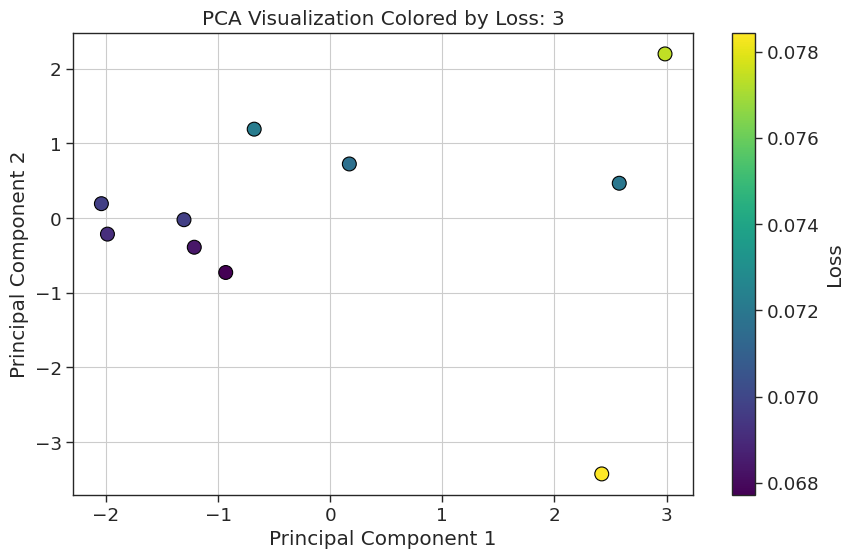

params
 [[0.0785498  0.20936395 0.07448236 0.06633331 0.10423241 0.46703812]
 [0.06315688 0.20503578 0.0824118  0.06987575 0.10857434 0.47094542]
 [0.02338489 0.20960866 0.08698389 0.07357755 0.11462381 0.49182117]
 [0.01872174 0.19999614 0.09624848 0.07743695 0.11812469 0.48947197]
 [0.05196469 0.1941957  0.09460828 0.07967082 0.11292141 0.4666391 ]
 [0.12480699 0.15449639 0.10692737 0.07960043 0.10924327 0.42492554]
 [0.25762585 0.12602614 0.09386061 0.0696613  0.09602633 0.3567997 ]
 [0.07788117 0.15235728 0.12030946 0.08927958 0.11865687 0.44151562]
 [0.28004378 0.09584961 0.11428236 0.04582537 0.09372471 0.37027416]
 [0.2146155  0.17595911 0.05376277 0.12508586 0.08628654 0.3442902 ]]
losses
 [0.06772264 0.06835516 0.06912598 0.06971623 0.0697275  0.07161798
 0.07197452 0.07216284 0.07741053 0.07843499]


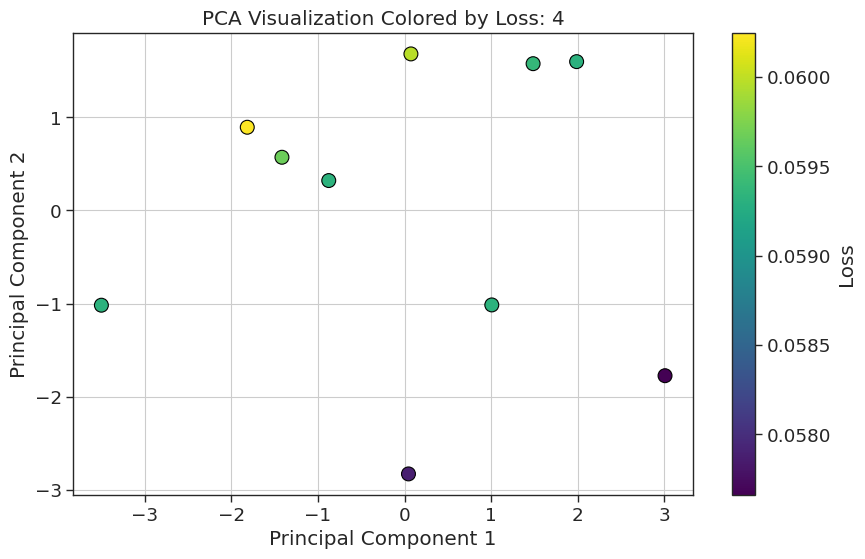

params
 [[0.07439788 0.22002867 0.14147188 0.05602123 0.09666801 0.41141236]
 [0.17748241 0.19462883 0.12541048 0.04887366 0.08551989 0.36808473]
 [0.05495851 0.21411413 0.16667981 0.12023736 0.08577409 0.358236  ]
 [0.12332311 0.20312256 0.14392485 0.0768782  0.08853684 0.3642144 ]
 [0.25749293 0.16757295 0.13175131 0.09451687 0.06694049 0.28172544]
 [0.15976825 0.18936577 0.14989217 0.10719553 0.07552051 0.31825772]
 [0.07078512 0.20953505 0.16604625 0.11933812 0.08127786 0.35301757]
 [0.17109868 0.18764369 0.14843635 0.11101213 0.06222347 0.31958565]
 [0.10972604 0.20336637 0.15906055 0.12307122 0.05778443 0.34699136]
 [0.1768756  0.18869852 0.14655517 0.11627483 0.0474427  0.32415316]]
losses
 [0.05765953 0.05788108 0.05931104 0.05931883 0.05932507 0.05932632
 0.05938268 0.05966288 0.05996652 0.0602468 ]


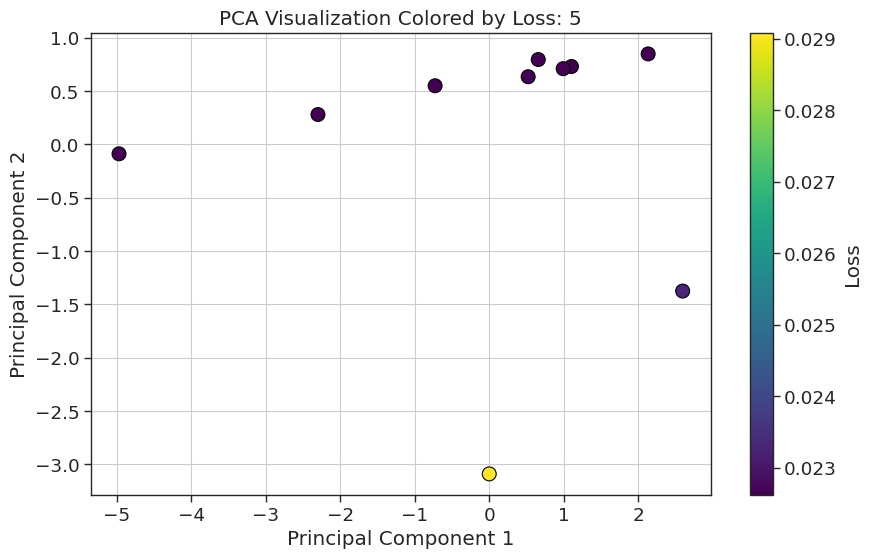

params
 [[0.14401089 0.21634535 0.14636023 0.06464663 0.10238871 0.32624817]
 [0.094566   0.2291722  0.15480089 0.06789038 0.10816558 0.34540498]
 [0.06672941 0.23609012 0.15954638 0.06995606 0.11119966 0.35647836]
 [0.09738799 0.22847013 0.15415813 0.06757139 0.10798069 0.34443167]
 [0.18577231 0.20631051 0.13922678 0.06113661 0.09745277 0.31010103]
 [0.10759601 0.22576204 0.15258665 0.06774169 0.10674718 0.3395664 ]
 [0.25691986 0.18812385 0.12696879 0.0559669  0.08873928 0.2832813 ]
 [0.11107152 0.22597483 0.15272763 0.06611866 0.1068766  0.33723074]
 [0.0334598  0.24747123 0.16539988 0.06127283 0.10612128 0.386275  ]
 [0.08171138 0.23584242 0.14834067 0.05558029 0.08814022 0.39038497]]
losses
 [0.02262336 0.02262859 0.02263112 0.02263794 0.02263928 0.02264322
 0.02264502 0.02265311 0.0232879  0.02908115]


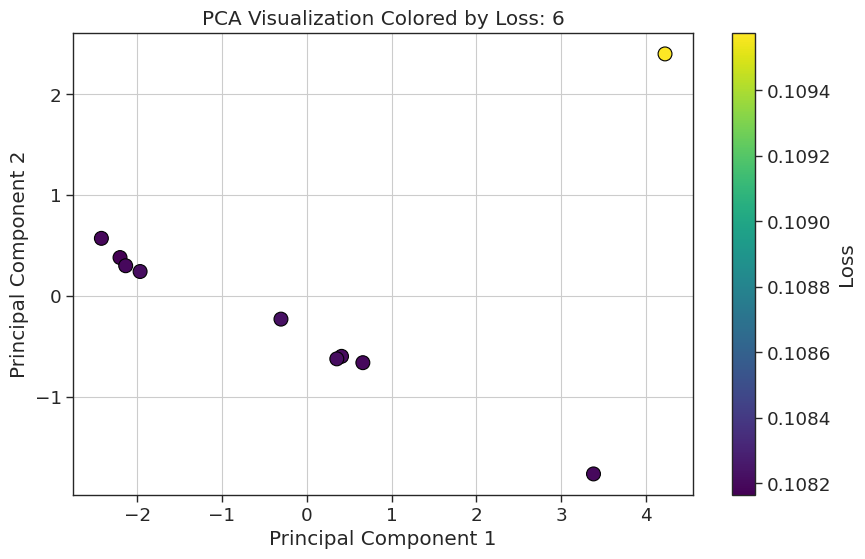

params
 [[0.04187459 0.21448833 0.15048905 0.06355666 0.09915127 0.4304401 ]
 [0.03187421 0.21692525 0.15173511 0.06450079 0.09844488 0.4365197 ]
 [0.04313634 0.2143008  0.1496204  0.06293585 0.09838436 0.43162227]
 [0.24850427 0.16850872 0.11793765 0.04926652 0.07748584 0.33829698]
 [0.14770253 0.19126567 0.13344336 0.05647426 0.08775423 0.38335994]
 [0.13866937 0.19319597 0.13478681 0.05695715 0.08906159 0.38732913]
 [0.1358713  0.19332437 0.13577583 0.05687185 0.08895342 0.38920325]
 [0.05037516 0.21288925 0.14875764 0.06262554 0.09818741 0.42716494]
 [0.11046248 0.19886136 0.13964659 0.05922768 0.09048763 0.40131423]
 [0.2780122  0.16970925 0.080869   0.06790594 0.06655101 0.3369526 ]]
losses
 [0.10816416 0.1081911  0.10819199 0.10819474 0.10819606 0.10820242
 0.10820958 0.10821092 0.10822348 0.10957562]


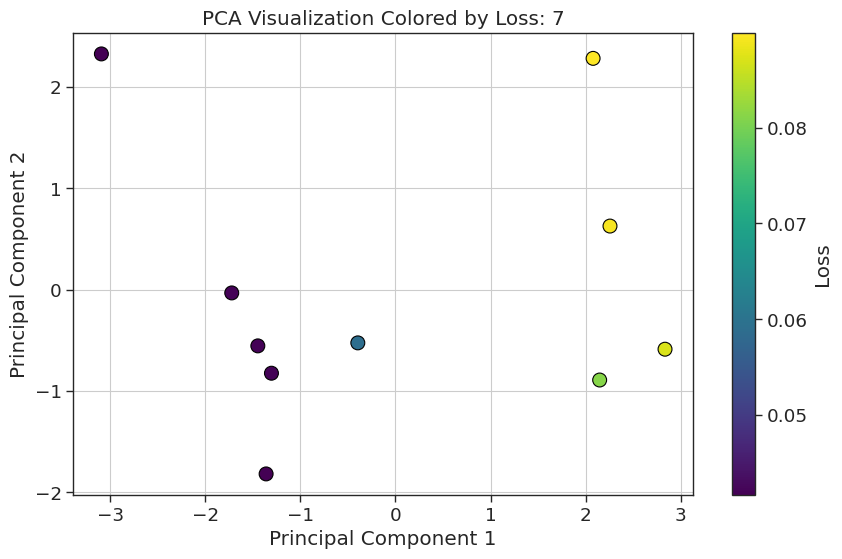

params
 [[0.27712324 0.15273437 0.12160067 0.0617389  0.07898625 0.30781657]
 [0.08319692 0.1947155  0.15370843 0.08080705 0.09691603 0.390656  ]
 [0.15983094 0.17922492 0.1388907  0.07712792 0.08090009 0.36402532]
 [0.11884516 0.18779688 0.14673518 0.08409202 0.08354568 0.37898505]
 [0.13599907 0.18327016 0.14283434 0.07886038 0.08186209 0.37717402]
 [0.09243657 0.17731602 0.16938664 0.12074155 0.07607479 0.36404443]
 [0.06065154 0.05913303 0.2643214  0.13629583 0.06583919 0.41375896]
 [0.0623074  0.0125092  0.30468556 0.14293359 0.06369497 0.41386932]
 [0.11166629 0.00106164 0.305301   0.14005008 0.06229086 0.37963006]
 [0.18639654 0.00366445 0.27005425 0.1329     0.03560609 0.37137866]]
losses
 [0.04163838 0.04171543 0.04188695 0.04194776 0.04195453 0.05889012
 0.08120926 0.0870904  0.08951375 0.08990659]


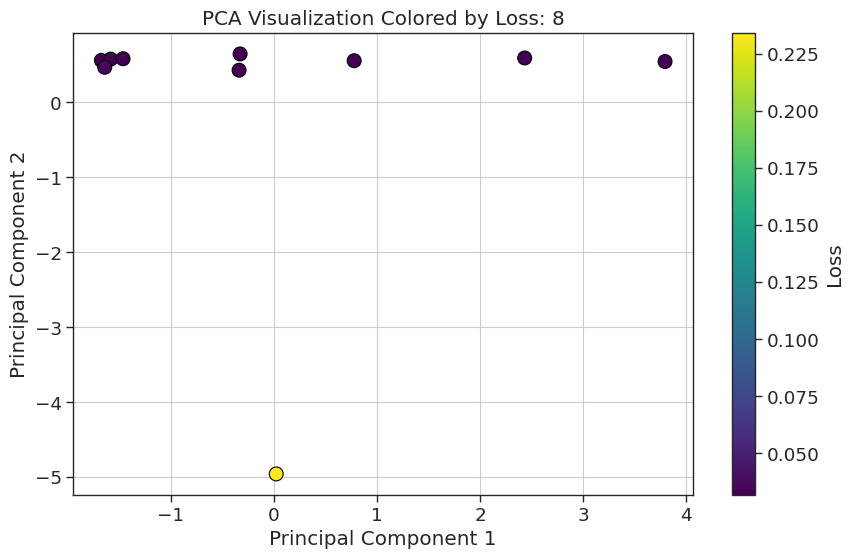

params
 [[0.1921513  0.20579366 0.10704083 0.08660772 0.10152768 0.30687883]
 [0.02619336 0.24743058 0.1289824  0.10410144 0.12203851 0.3712537 ]
 [0.03161976 0.24648584 0.1284756  0.10359251 0.1221201  0.3677062 ]
 [0.12569417 0.22220196 0.1155238  0.09296036 0.11049575 0.33312386]
 [0.24592845 0.19177233 0.10020427 0.08006348 0.09489188 0.28713962]
 [0.03680953 0.24487069 0.12847488 0.10358171 0.12104277 0.36522037]
 [0.08358324 0.23355211 0.12099143 0.09907366 0.1156714  0.34712815]
 [0.06967553 0.23601691 0.12353615 0.09781007 0.11299897 0.35996237]
 [0.04688407 0.25159952 0.13890252 0.09884752 0.12820876 0.33555764]
 [0.1124089  0.02811219 0.17076857 0.07654422 0.11365212 0.49851403]]
losses
 [0.03166438 0.03167731 0.031689   0.03170971 0.03173829 0.03174214
 0.03174783 0.03190206 0.03518214 0.23426053]


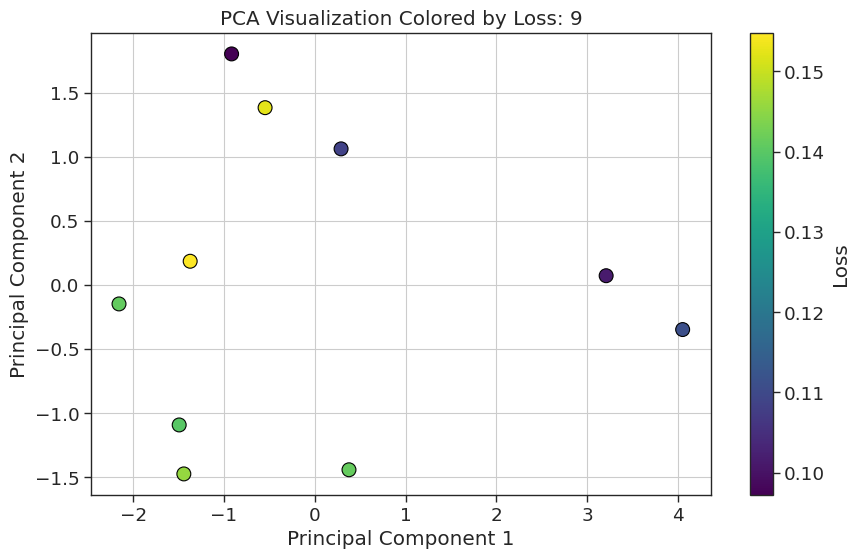

params
 [[0.08849313 0.14275101 0.13262865 0.04616361 0.12959692 0.46036667]
 [0.38741446 0.10078809 0.08447327 0.02889864 0.08661327 0.31181222]
 [0.1810209  0.12572803 0.11527289 0.04835894 0.12071352 0.40890568]
 [0.4501422  0.09127027 0.07837722 0.02818374 0.07684169 0.2751849 ]
 [0.07380009 0.09663077 0.1911924  0.06359179 0.15203562 0.4227493 ]
 [0.02290499 0.11547884 0.18800583 0.06534984 0.15802231 0.45023823]
 [0.20723306 0.08452641 0.16418266 0.05843644 0.12823737 0.35738406]
 [0.08156513 0.08995404 0.19709635 0.06761906 0.1525767  0.4111887 ]
 [0.13763967 0.12979893 0.1659718  0.1102088  0.09319685 0.363184  ]
 [0.07332219 0.11198773 0.18587685 0.08395789 0.11852259 0.42633277]]
losses
 [0.09723967 0.1014556  0.10857634 0.11116454 0.1399231  0.14093523
 0.1411706  0.14562914 0.15253109 0.15478808]


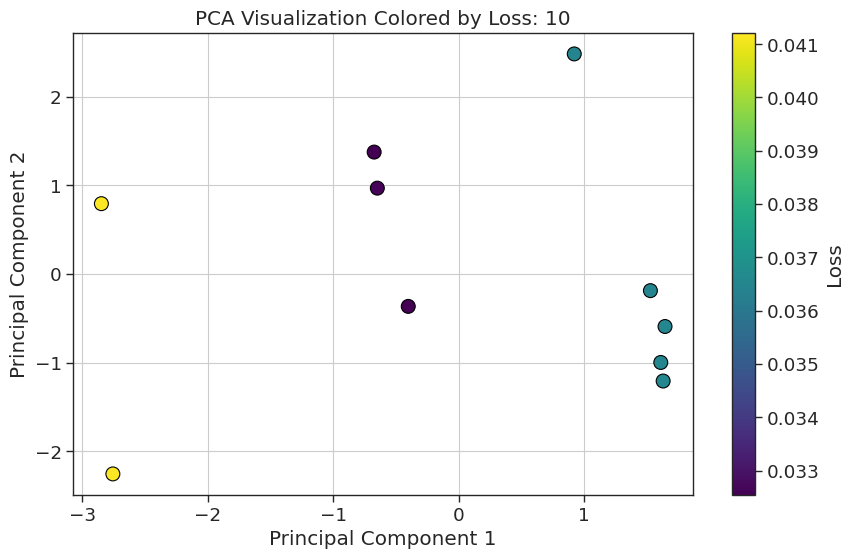

params
 [[0.08553134 0.20685141 0.11234247 0.11633279 0.11199678 0.36694524]
 [0.16789201 0.1882629  0.10257816 0.10593303 0.10343423 0.33189964]
 [0.14992903 0.19226839 0.10483222 0.1058022  0.10571027 0.34145787]
 [0.23094718 0.12449375 0.13476625 0.10480288 0.06437085 0.3406191 ]
 [0.10574725 0.14512841 0.15613733 0.12224288 0.07446515 0.39627898]
 [0.06771767 0.15175866 0.16270156 0.12713018 0.07983552 0.41085634]
 [0.08688505 0.14779736 0.15937    0.12495445 0.07563203 0.40536112]
 [0.05797921 0.1529999  0.16442285 0.12839769 0.08155661 0.4146437 ]
 [0.17443083 0.15555365 0.20578197 0.04769621 0.11802121 0.29851612]
 [0.03595365 0.18157966 0.2405063  0.05541573 0.13463503 0.35190958]]
losses
 [0.03254312 0.03255589 0.03263669 0.0364807  0.03649959 0.03650751
 0.03651201 0.03652777 0.04117438 0.04121014]


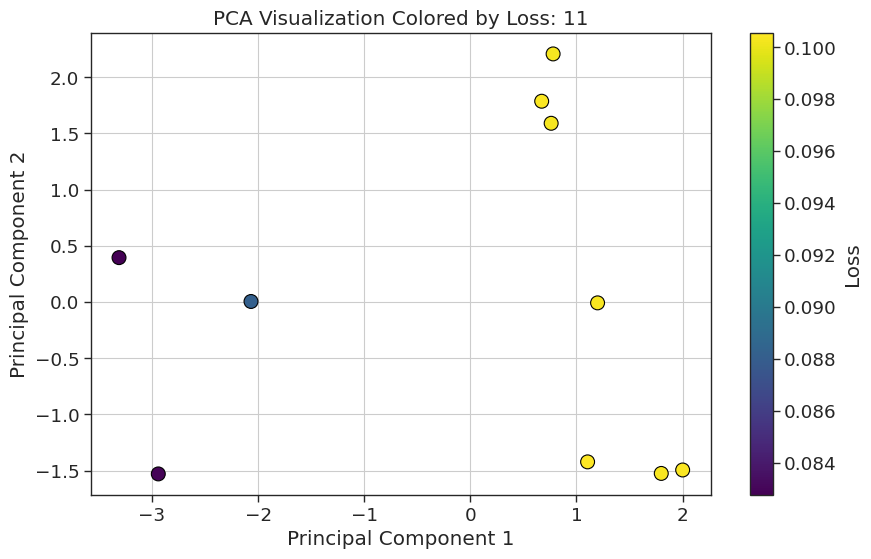

params
 [[0.08415601 0.24672171 0.09572044 0.11153553 0.04872089 0.41314545]
 [0.0381595  0.2597612  0.10087363 0.11694482 0.05303031 0.43123046]
 [0.06755675 0.24277928 0.10914214 0.11939355 0.06469062 0.39643773]
 [0.13197622 0.24357218 0.17143002 0.14654212 0.06081833 0.2456611 ]
 [0.14894333 0.23882903 0.16899979 0.14224765 0.06361593 0.23736429]
 [0.09353314 0.25436306 0.17920877 0.15204874 0.0647459  0.25610042]
 [0.05785519 0.2638374  0.18679972 0.15706521 0.07190299 0.26253945]
 [0.1354285  0.24213417 0.17202578 0.14555469 0.05961791 0.245239  ]
 [0.06198858 0.26288176 0.1847746  0.15414712 0.07770853 0.2584994 ]
 [0.05253243 0.2644998  0.18911293 0.15746208 0.05940922 0.27698353]]
losses
 [0.08275893 0.08292362 0.08814566 0.10031977 0.10032954 0.10034806
 0.10038078 0.10041782 0.10045008 0.1005462 ]


In [8]:
for i, file_name in enumerate(pt_files): #load all training files previously created
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().numpy()
    losses = loss.detach().numpy()

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Plot the results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                        c=losses, cmap='viridis', edgecolor='k', s=100)
    plt.colorbar(scatter, label='Loss')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Visualization Colored by Loss: {i}')
    plt.grid(True)
    plt.show()
    print("params\n", data)
    print("losses\n", losses)
    if i > 10:
        break

In [9]:
interesting_processes = list(pt_files[i] for i in [0,1,7,9])

In [10]:
# Initialize an empty list to store data from all files
all_params = []

# Iterate through all files in pt_files
for file_name in interesting_processes:
    file_path = os.path.join(optim_path, file_name)
    # Load parameters from the file
    params, _ = torch.load(file_path, weights_only=True)
    all_params.append(params.detach().numpy())

# Concatenate all parameters into a single numpy array
all_params = np.vstack(all_params)

# Fit PCA to the concatenated data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_params)

# Print the shape of the principal components
print(f"Principal components shape: {principal_components.shape}")

Principal components shape: (40, 2)


/tmp/ipykernel_1221296/936481636.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_1221296/936481636.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])


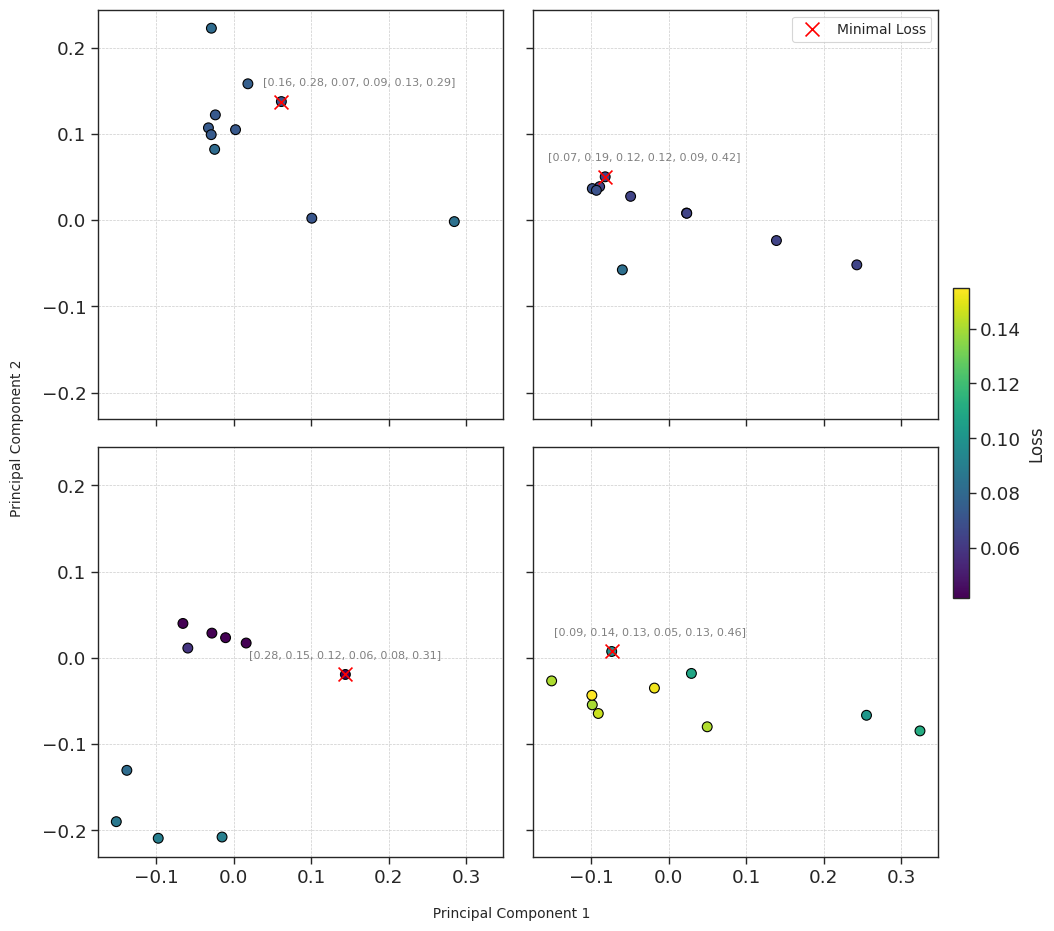

In [11]:
# Create subplots with a clean style
from matplotlib.colors import Normalize
from matplotlib import cm

# Plot with global normalization
all_losses = []
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    all_losses.append(loss.detach().cpu().numpy())
all_losses_flat = np.concatenate(all_losses)
norm = Normalize(vmin=np.min(all_losses_flat), vmax=np.max(all_losses_flat))
cmap = cm.get_cmap('viridis')



fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot with global normalization
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().cpu().numpy()
    losses = loss.detach().cpu().numpy()

    # Apply PCA
    principal_components = pca.transform(data)

    # Use global colormap norm
    scatter = axes[i].scatter(
        principal_components[:, 0],
        principal_components[:, 1],
        c=losses,
        cmap=cmap,
        norm=norm,
        edgecolor='k',  # Add black edges for better visibility
        s=50
    )

    # Highlight the minimum loss point
    min_loss_idx = np.argmin(losses)
    axes[i].scatter(
        principal_components[min_loss_idx, 0],
        principal_components[min_loss_idx, 1],
        color='red',
        marker='x',
        s=100,
        label="Minimal Loss" if i == 1 else None  # Ensure label only appears in figure 2
    )
    if i == 1:  # Add legend only for figure 2
        axes[i].legend(loc="upper right", fontsize=10)


    # Add the real data point above the best point
    if i == 0:  # Move the first list significantly to the right
        principal_components[:, 0] += 0.1
    elif i == 1:  # Move the second list slightly to the right
        principal_components[:, 0] += 0.05
    elif i == 3:  # Move the fourth list slightly to the right
        principal_components[:, 0] += 0.05

    real_data_point = np.round(data[min_loss_idx], 2)
    axes[i].text(
        principal_components[min_loss_idx, 0],
        principal_components[min_loss_idx, 1] + 0.02,  # Offset slightly above the point
        f"{[round(x, 2) for x in real_data_point.tolist()]}",
        color="grey",
        fontsize=8,
        ha="center"
    )

    # Add gridlines
    axes[i].grid(True, linestyle='--', linewidth=0.5)

# Shared axis labels
fig.text(0.5, 0.02, '          Principal Component 1', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Principal Component 2', va='center', rotation='vertical', fontsize=10)

# Add shared colorbar with global normalization
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical', fraction=0.02, pad=0)
pos = cbar.ax.get_position()
cbar.ax.set_position([
    pos.x0 + 0.0787,  # shift right
    pos.y0,
    pos.width,
    pos.height
])
cbar.set_label('Loss', fontsize=12)

# Add a single title for the entire figure
# fig.suptitle('     Local Optima for Time Discretizations for Four Different Diffusion Processes', fontsize=16, y=0.92)

# Adjust layout for tighter spacing
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
# Save the figure as a high-resolution image with additional white padding on the right
plt.savefig(
    os.path.join(img_save_dir, "Local_Optima_for_Time_Discretizations_for_Four_Different_Diffusion_Processes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5
)

# Show the plot
plt.show()


In [13]:
n_vis = 3
pt_files = [f for f in os.listdir(optim_path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:n_vis]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross'][:n_vis]  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(optim_path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)


all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

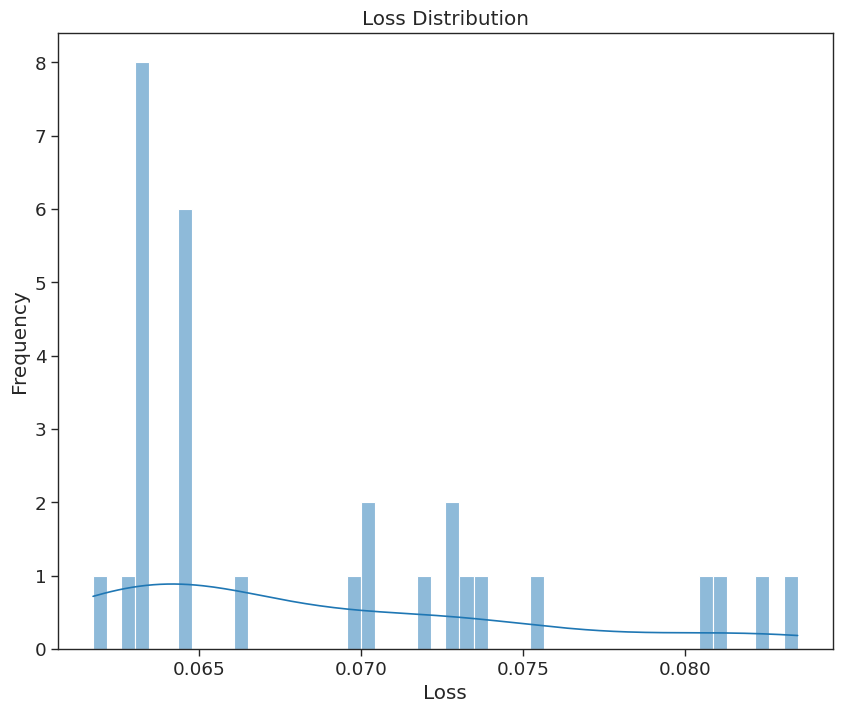

In [14]:
plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()


### Visualize Different Timestep Paths

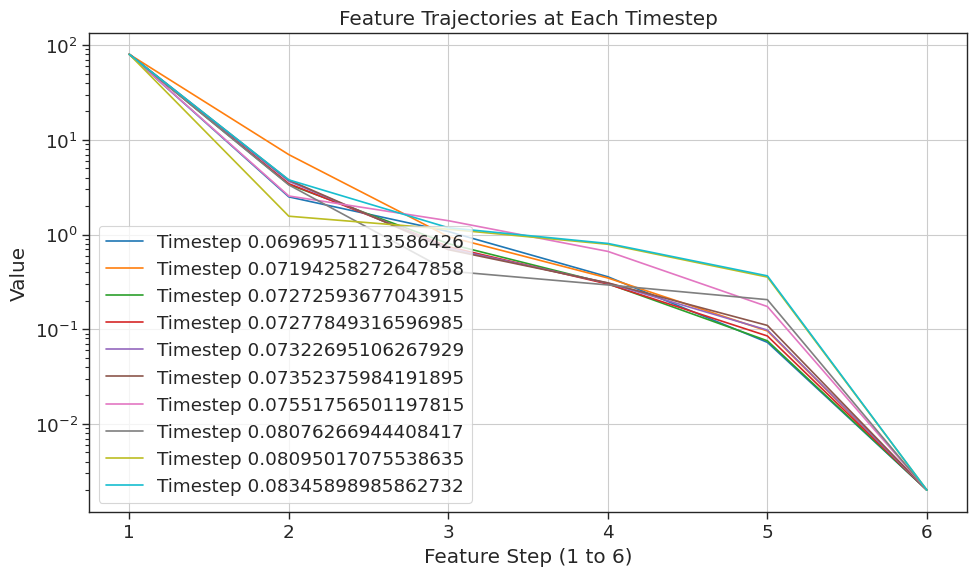

In [15]:
optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:1]

for i, file_name in enumerate(pt_files): #load all training files previously created
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)

    losses = loss.detach().numpy()
    timesteps = dis_model.convert(params).detach().numpy()
    feature_steps = torch.arange(1, 7)  # x-axis: steps 1 through 6

    plt.figure(figsize=(10, 6))

    for loss, timestep in zip(losses,timesteps):
        plt.plot(feature_steps, timestep, label=f'Timestep {loss}')

    plt.xlabel('Feature Step (1 to 6)')
    plt.ylabel('Value')
    plt.yscale('log')
    plt.title('Feature Trajectories at Each Timestep')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1221296/1901666234.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



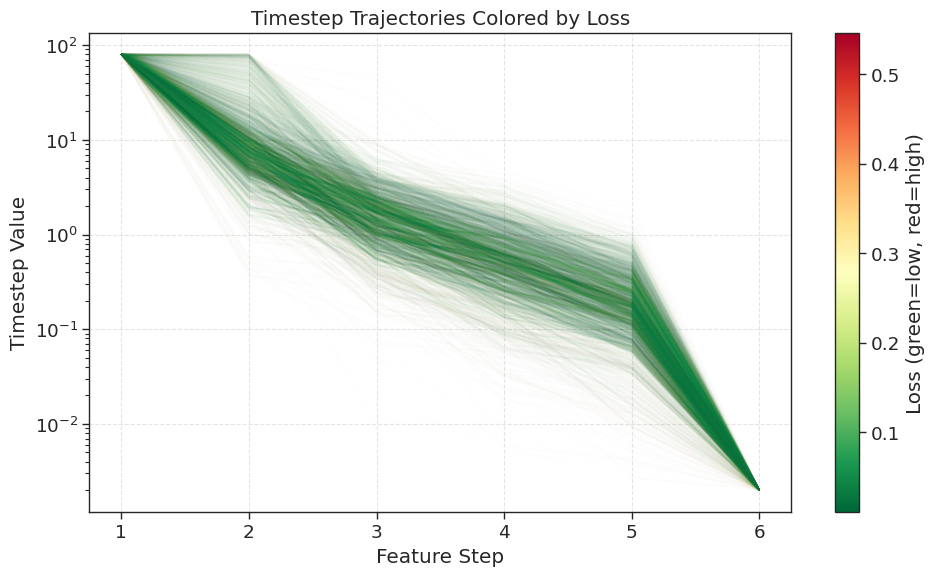

In [16]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:500]  # Show more trajectories

all_trajectories = []
all_losses = []

for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params).detach().cpu().numpy()
    losses = loss.detach().cpu().numpy()
    # If multiple trials, add all; else, add single
    if timesteps.ndim == 2:
        for t, l in zip(timesteps, losses):
            all_trajectories.append(t)
            all_losses.append(l)
    else:
        all_trajectories.append(timesteps)
        all_losses.append(losses)

all_trajectories = np.array(all_trajectories)
all_losses = np.array(all_losses)

# Normalize losses for colormap (green=low, red=high)
norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

plt.figure(figsize=(10, 6))
for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
    plt.plot(feature_steps, traj, color=color, alpha=0.008, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
# Add colorbar to the current figure and axes
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Loss (green=low, red=high)')

plt.xlabel('Feature Step')
plt.ylabel('Timestep Value')
plt.yscale('log')
plt.title('Timestep Trajectories Colored by Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1221296/1336331733.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



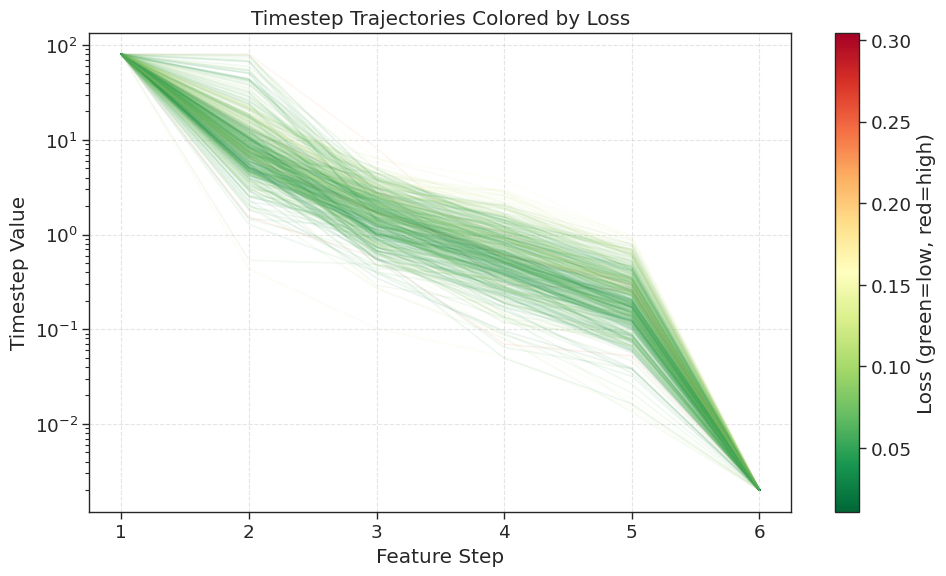

In [17]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:500]  # Show more trajectories

all_trajectories = []
all_losses = []

for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
    losses = loss[0:1].detach().cpu().numpy()
    # If multiple trials, add all; else, add single
    if timesteps.ndim == 2:
        for t, l in zip(timesteps, losses):
            all_trajectories.append(t)
            all_losses.append(l)
    else:
        all_trajectories.append(timesteps)
        all_losses.append(losses)

all_trajectories = np.array(all_trajectories)
all_losses = np.array(all_losses)

# Normalize losses for colormap (green=low, red=high)
norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

plt.figure(figsize=(10, 6))
for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
    plt.plot(feature_steps, traj, color=color, alpha=0.08, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
# Add colorbar to the current figure and axes
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Loss (green=low, red=high)')

plt.xlabel('Feature Step')
plt.ylabel('Timestep Value')
plt.yscale('log')
plt.title('Timestep Trajectories Colored by Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1221296/2533839177.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



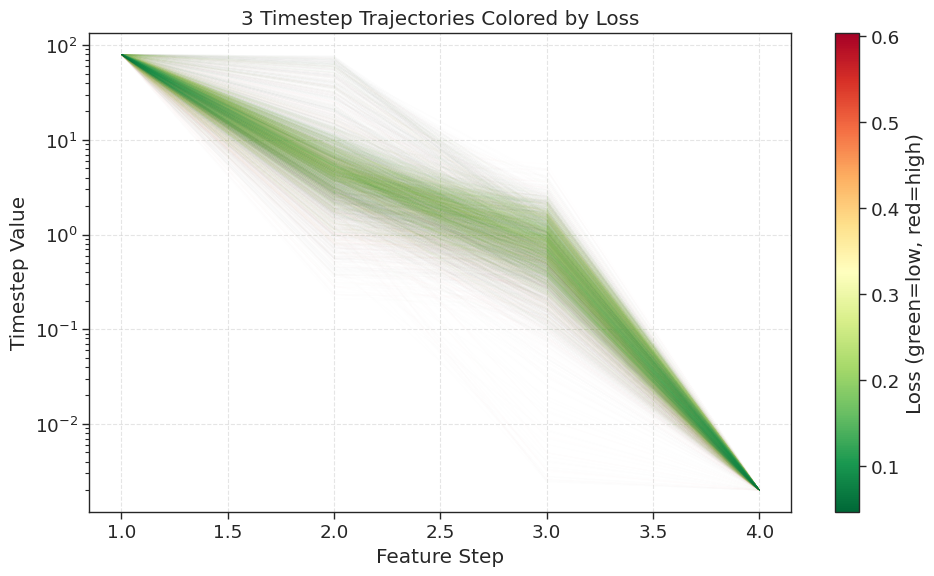

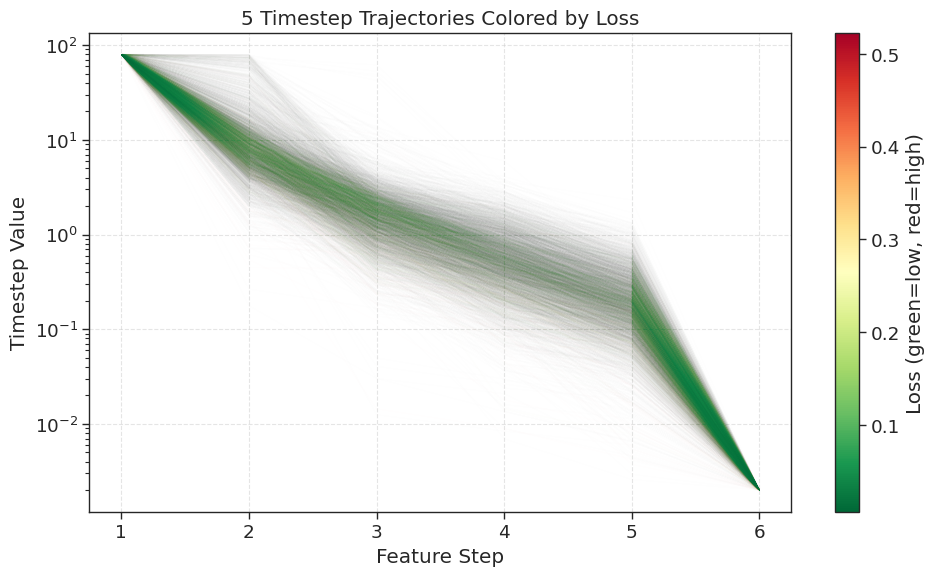

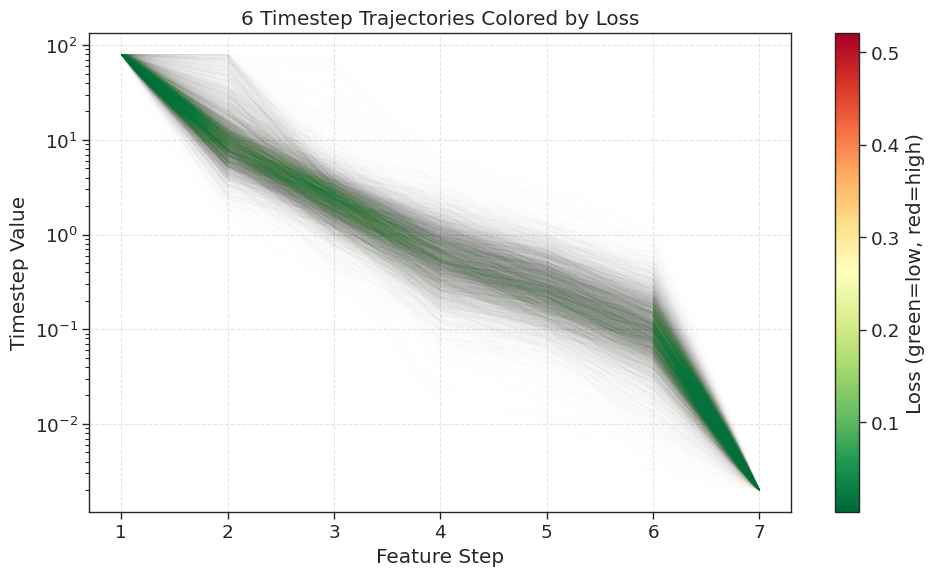

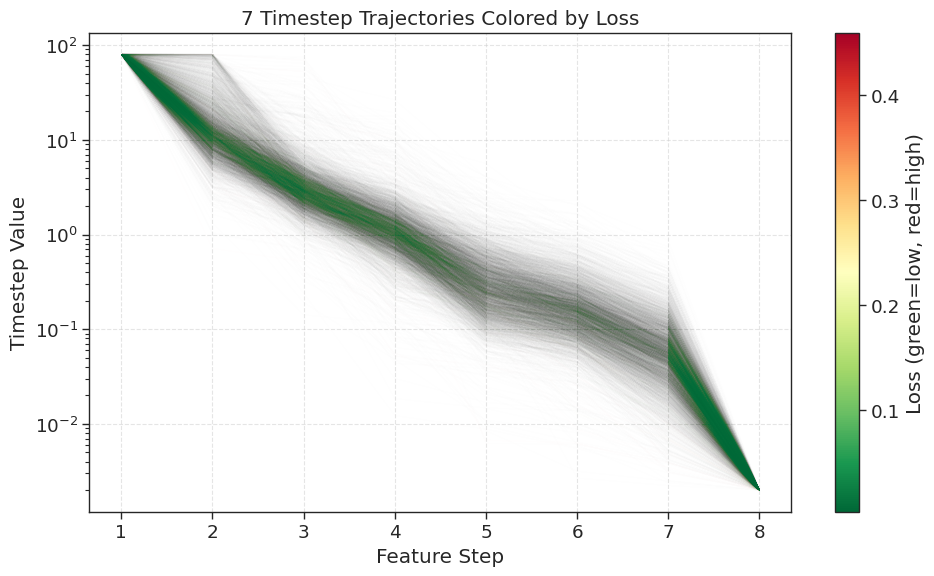

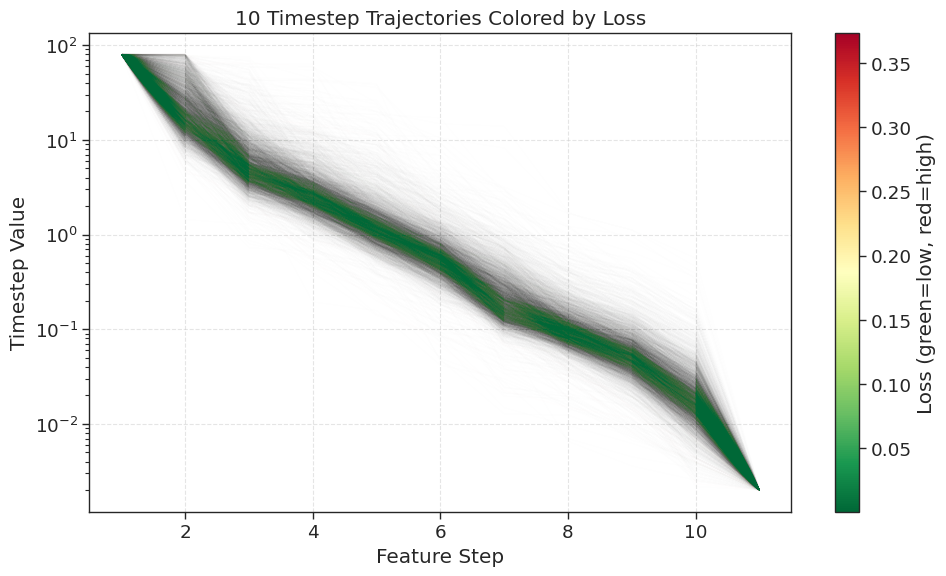

In [18]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

steps_list = [3, 5, 6, 7, 10]
for steps in steps_list:
    optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
    pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:5000]  # Show more trajectories

    all_trajectories = []
    all_losses = []
    for file_name in pt_files:
        file_path = os.path.join(optim_path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
        losses = loss[0:1].detach().cpu().numpy()
        # If multiple trials, add all; else, add single
        if timesteps.ndim == 2:
            for t, l in zip(timesteps, losses):
                all_trajectories.append(t)
                all_losses.append(l)
        else:
            all_trajectories.append(timesteps)
            all_losses.append(losses)

    all_trajectories = np.array(all_trajectories)
    all_losses = np.array(all_losses)

    # Normalize losses for colormap (green=low, red=high)
    norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
    colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

    feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

    plt.figure(figsize=(10, 6))
    for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
        plt.plot(feature_steps, traj, color=color, alpha=0.002, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
    # Add colorbar to the current figure and axes
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Loss (green=low, red=high)')

    plt.xlabel('Feature Step')
    plt.ylabel('Timestep Value')
    plt.yscale('log')
    plt.title(f'{steps} Timestep Trajectories Colored by Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1221296/874077577.py:73: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



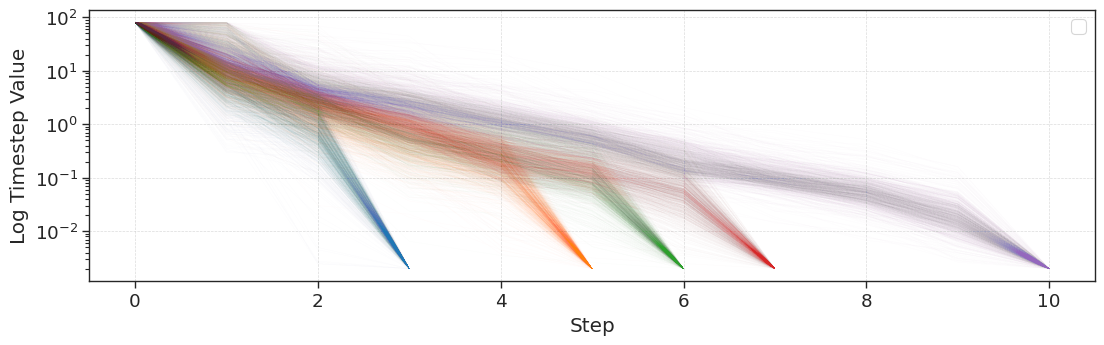

In [20]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

# Plot all trajectories for different steps in one plot, colored by steps (not loss), and plot average per steps

import matplotlib.pyplot as plt
import numpy as np

n = 1000
steps_list = [3, 5, 6, 7, 10]
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(12, 4))

# Add n_params (best params) for each steps in black
n_params_dict = {
    3: torch.tensor([8.0000e+01, 5.9884e+00, 7.5587e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    5: torch.tensor([8.0000e+01, 1.0621e+01, 2.5949e+00, 8.5124e-01, 2.7130e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    6: torch.tensor([8.0000e+01, 1.2389e+01, 3.4480e+00, 1.2409e+00, 4.1899e-01, 1.6694e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    7: torch.tensor([8.0000e+01, 1.2833e+01, 3.7612e+00, 1.5670e+00, 3.4353e-01, 2.2291e-01, 7.3629e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    10: torch.tensor([8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
                      2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
}

# Plot all "best" (black) lines with a single label "LD3" only for the first one
# label_added = False
# for idx, steps in enumerate(steps_list):
#     if steps in n_params_dict:
#         n_params = n_params_dict[steps]
#         feature_steps_n = np.arange(0, len(n_params))
#         label = "LD3" if not label_added else None
#         plt.plot(feature_steps_n, n_params, color='black', linewidth=0.5, label=label, zorder=10)
#         label_added = True

for steps, color in zip(steps_list, color_list):
    optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
    pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:n]

    all_trajectories = []
    for file_name in pt_files:
        file_path = os.path.join(optim_path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
        if timesteps.ndim == 2:
            for t in timesteps:
                all_trajectories.append(t)
        else:
            all_trajectories.append(timesteps)

    all_trajectories = np.array(all_trajectories).squeeze()
    feature_steps = np.arange(0, all_trajectories.shape[1])

    # Plot all trajectories with low alpha
    for i, traj in enumerate(all_trajectories):
        plt.plot(feature_steps, traj, color=color, alpha=10 / n, linewidth=0.5)

    # # Plot average trajectory in bold
    # avg_traj = np.mean(all_trajectories, axis=0)
    # plt.plot(feature_steps, avg_traj, color=color, linewidth=1, label=f'{steps} steps')

plt.xlabel('Step')
plt.ylabel('Log Timestep Value')
plt.yscale('log')
# plt.title('Timestep Trajectories for Different Steps (Colored by Steps)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join(img_save_dir, f"Timestep_Trajectories_for_Different_Steps_WithoutExtra_{n}.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()



### Try to cluster timesteps

In [ ]:
n = 50000 #10000
optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:n]

all_timesteps = []
all_loses = []
for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)[0].detach().cpu().numpy()
    losses = loss[0:1].detach().cpu().numpy()

    all_timesteps.append(timesteps)
    all_loses.append(losses)

In [ ]:
all_timesteps_np = np.array(all_timesteps).squeeze()
all_loses_np = np.array(all_loses).squeeze()

#filter out all loses and mask params under 95percentile
percentile = np.percentile(all_loses_np, 95)
mask = all_loses_np < percentile
all_timesteps_np = all_timesteps_np[mask]
all_loses_np = all_loses_np[mask]

In [ ]:
n_extremes = 5

In [ ]:
#normalize all timesteps to range [0, 1]
# Normalize all timesteps column-wise to range [0, 1]
all_timesteps_normalized_np = (all_timesteps_np - np.min(all_timesteps_np, axis=0)) / (np.max(all_timesteps_np, axis=0) - np.min(all_timesteps_np, axis=0) + 1e-8)

# Compute the sum of each trajectory
sums = all_timesteps_normalized_np.sum(axis=1)

# Get indices of the 5 largest and 5 smallest summed trajectories
largest_indices = np.argsort(sums)[-n_extremes:][::-1]
smallest_indices = np.argsort(sums)[:n_extremes]

print("Indices of 5 largest summed trajectories:", largest_indices)
print("Indices of 5 smallest summed trajectories:", smallest_indices)

# Plot the 5 largest and 5 smallest summed trajectories
plt.figure(figsize=(12, 4))
# Plot largest summed trajectories (red) with a single label
for i, idx in enumerate(largest_indices):
    label = 'Largest summed' if i == 0 else None
    plt.plot(all_timesteps_np[idx], label=label, alpha=0.5, color='red')

# Plot smallest summed trajectories (blue) with a single label
for i, idx in enumerate(smallest_indices):
    label = 'Smallest summed' if i == 0 else None
    plt.plot(all_timesteps_np[idx], label=label, alpha=0.5, color='blue')
plt.xlabel('Step')
plt.ylabel('Log Timestep Value')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
# Style: match the style from the reference plot
plt.savefig(
    os.path.join(img_save_dir, "Timestep_TrajectoriesExtremes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()


In [ ]:
#plot the corresponding images
img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"

import os
from PIL import Image
import matplotlib.pyplot as plt

indices = list(largest_indices) + list(smallest_indices)
titles = ['Largest'] * n_extremes + ['Smallest'] * n_extremes

fig, axes = plt.subplots(2, n_extremes, figsize=(15, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

for i, idx in enumerate(indices):
    fname = f"{idx:06d}.png"
    fpath = os.path.join(img_path, fname)
    img = Image.open(fpath)
    ax = axes[i // n_extremes, i % n_extremes]
    ax.imshow(img)
    ax.set_title(f"{titles[i]} {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Plot the corresponding images with "Largest" and "Smallest" on the left,
# no whitespace between images, and black boxes around images
import os
from PIL import Image
import numpy as np
from scipy.stats import entropy
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.filters import sobel
from skimage.feature import canny
import matplotlib.pyplot as plt


def shannon_entropy(img):
    """Calculate the Shannon entropy of the image."""
    if img.mode != 'L':
        img_gray = img.convert('L')
    else:
        img_gray = img
    arr = np.array(img_gray).flatten()
    hist, _ = np.histogram(arr, bins=256, range=(0, 255), density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def color_entropy(img):
    """Calculate the entropy for each color channel and return the mean."""
    arr = np.array(img)
    entropies = []
    for c in range(arr.shape[2]):
        hist, _ = np.histogram(arr[..., c].flatten(), bins=256, range=(0, 255), density=True)
        hist = hist[hist > 0]
        entropies.append(entropy(hist, base=2))
    return np.mean(entropies)

def canny_edge_complexity(img):
    """Calculate the number of edge pixels using Canny edge detector."""
    arr = np.array(img.convert('L')) / 255.0
    edges = canny(arr)
    return np.sum(edges)

def texture_lbp(img):
    """Calculate the mean LBP value as a simple texture descriptor."""
    arr = np.array(img.convert('L'))
    lbp = local_binary_pattern(arr, P=8, R=1, method='uniform')
    return np.mean(lbp)

img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated/optimal_n10"

fig, axes = plt.subplots(2, n_extremes, figsize=(2 * n_extremes, 5))
fig.subplots_adjust(wspace=1.5, hspace=0)

# Add "Largest" and "Smallest" labels on the left
axes[0, 0].set_ylabel("Largest", fontsize=14, rotation=0, labelpad=60, va='center')
axes[1, 0].set_ylabel("Smallest", fontsize=14, rotation=0, labelpad=60, va='center')

indices = list(largest_indices) + list(smallest_indices)

for i, idx in enumerate(indices):
    fname = f"{idx}.png"
    fpath = os.path.join(img_path, fname)
    img = Image.open(fpath)
    row = i // n_extremes
    col = i % n_extremes
    ax = axes[row, col]
    ax.imshow(img)
    ax.axis('on')
    # Draw black box around image
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Calculate metrics
    shannon_ent = shannon_entropy(img)
    color_ent = color_entropy(img)
    canny_complex = canny_edge_complexity(img)
    lbp_texture = texture_lbp(img)

    # Write metrics below the image
    additional_line = ""
    if i < n_extremes:
        additional_line = "\n\n"
    else:
        additional_line = ""
    ax.text(
        0.5, -0.05,
        f"Shannon: {shannon_ent:.2f}\n"
        f"Color: {color_ent:.2f}\n"
        f"Canny: {canny_complex:.0f}\n"
        f"LBP: {lbp_texture:.2f}{additional_line}",
        transform=ax.transAxes,
        fontsize=8,
        ha='center',
        va='top'
    )

plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(img_save_dir, "Images_TrajectoriesExtremes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()


In [ ]:
from tqdm import tqdm

# Calculate metrics for the largest and smallest 1000 images


# Use the indices of the largest and smallest summed trajectories
n_largest = 1000
n_smallest = 1000

largest_indices_1000 = np.argsort(sums)[-n_largest:][::-1]
smallest_indices_1000 = np.argsort(sums)[:n_smallest]

img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated/optimal_n10"

def compute_metrics_for_indices(indices):
    shannon_list = []
    color_list = []
    canny_list = []
    lbp_list = []
    for idx in tqdm(indices, desc="Processing images"):
        fname = f"{idx}.png"
        fpath = os.path.join(img_path, fname)
        if not os.path.exists(fpath):
            continue
        img = Image.open(fpath)
        shannon_list.append(shannon_entropy(img))
        color_list.append(color_entropy(img))
        canny_list.append(canny_edge_complexity(img))
        lbp_list.append(texture_lbp(img))
    return {
        "shannon": np.array(shannon_list),
        "color": np.array(color_list),
        "canny": np.array(canny_list),
        "lbp": np.array(lbp_list),
    }

largest_1000_metrics = compute_metrics_for_indices(largest_indices_1000)
smallest_1000_metrics = compute_metrics_for_indices(smallest_indices_1000)

print("Largest 1000 metrics (mean):")
for k, v in largest_1000_metrics.items():
    print(f"  {k}: {np.mean(v):.4f}")

print("Smallest 1000 metrics (mean):")
for k, v in smallest_1000_metrics.items():
    print(f"  {k}: {np.mean(v):.4f}")

#### Calculate Mean, Mean of Best, Std internal, coefficient of variation internal mean, coefficient of variation global
 

In [ ]:
import numpy as np
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]

opt_t_clever_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_clever_initialisation"
opt_t_clever_files = [f for f in os.listdir(opt_t_clever_dir) if f.endswith('.pth')]


In [ ]:


for name, files, path in zip(["opt_t", "opt_t_clever", "100_10"], [opt_t_files, opt_t_clever_files, pt_files], [opt_t_dir, opt_t_clever_dir, optim_path]):
    all_losses = []
    best_losses = []
    std_deviations = []
    coefficients_of_variation = []


    for i, file_name in enumerate(files):
        file_path = os.path.join(path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        all_losses.append(loss.detach().cpu().numpy())
        best_losses.append(loss.detach().cpu().numpy()[0])
        std_deviations.append(np.std(loss.detach().cpu().numpy()))
        coefficients_of_variation.append(std_deviations[-1] / np.mean(loss.detach().cpu().numpy()))
    all_losses_flat = np.concatenate(all_losses)


    mean_loss = np.mean(all_losses_flat)
    std_loss = np.std(all_losses_flat)
    mean_best_loss = np.mean(best_losses)
    std_best_loss = np.std(best_losses)
    mean_std_deviation = np.mean(std_deviations)
    std_std_deviation = np.std(std_deviations)
    mean_coefficient_of_variation = np.mean(coefficients_of_variation)
    std_coefficient_of_variation = np.std(coefficients_of_variation)


    print(f"Results for {name}:")
    print(f"Mean loss: {mean_loss:.4f}")
    print(f"Std loss: {std_loss:.4f}")
    print(f"Mean of best losses: {mean_best_loss:.4f}")
    print(f"Std of best losses: {std_best_loss:.4f}")
    print(f"Internal std deviations: {mean_std_deviation:.4f}")
    # print(f"Std of std deviations: {std_std_deviation:.4f}")
    # print(f"Mean coefficient of variation: {mean_coefficient_of_variation:.4f}")
    # print(f"Std coefficient of variation: {std_coefficient_of_variation:.4f}")


#### all 100x1 runs

In [ ]:
for name, files, path in ["opt_t_final_3", "opt_t_final_5", "opt_t_final_7", "opt_t_final_10"]:
    all_losses = []
    best_losses = []
    std_deviations = []
    coefficients_of_variation = []


    for i, file_name in enumerate(files):
        file_path = os.path.join(path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        all_losses.append(loss.detach().cpu().numpy())
        best_losses.append(loss.detach().cpu().numpy()[0])
        std_deviations.append(np.std(loss.detach().cpu().numpy()))
        coefficients_of_variation.append(std_deviations[-1] / np.mean(loss.detach().cpu().numpy()))
    all_losses_flat = np.concatenate(all_losses)


    mean_loss = np.mean(all_losses_flat)
    std_loss = np.std(all_losses_flat)
    mean_best_loss = np.mean(best_losses)
    std_best_loss = np.std(best_losses)
    mean_std_deviation = np.mean(std_deviations)
    std_std_deviation = np.std(std_deviations)
    mean_coefficient_of_variation = np.mean(coefficients_of_variation)
    std_coefficient_of_variation = np.std(coefficients_of_variation)


    print(f"Results for {name}:")
    print(f"Mean loss: {mean_loss:.4f}")
    print(f"Std loss: {std_loss:.4f}")
    print(f"Mean of best losses: {mean_best_loss:.4f}")
    print(f"Std of best losses: {std_best_loss:.4f}")
    print(f"Internal std deviations: {mean_std_deviation:.4f}")
    # print(f"Std of std deviations: {std_std_deviation:.4f}")
    # print(f"Mean coefficient of variation: {mean_coefficient_of_variation:.4f}")
    # print(f"Std coefficient of variation: {std_coefficient_of_variation:.4f}")

##### Timestep Distribution

In [ ]:
all_timesteps = []
for file in pt_files:
    file_path = os.path.join(optim_path, file)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)
    all_timesteps.append(timesteps.detach().numpy())
all_timesteps = np.stack(all_timesteps)
all_timesteps = all_timesteps.reshape(-1, steps+1)

# Remove the top 1% of outliers
percentile_99 = np.percentile(all_timesteps, 99, axis=0)
filtered_timesteps = all_timesteps[np.all(all_timesteps <= percentile_99, axis=1)]

# Plot histogram for each column in filtered_timesteps
num_columns = filtered_timesteps.shape[1]
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in rows
    plt.hist(filtered_timesteps[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Timestep {i}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
all_timesteps = []
for file in opt_t_clever_files:
    file_path = os.path.join(opt_t_clever_dir, file)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)
    all_timesteps.append(timesteps.detach().numpy())
all_timesteps = np.stack(all_timesteps)
all_timesteps = all_timesteps.reshape(-1, steps+1)

# Remove the top 1% of outliers
percentile_99 = np.percentile(all_timesteps, 99, axis=0)
filtered_timesteps = all_timesteps[np.all(all_timesteps <= percentile_99, axis=1)]

# Plot histogram for each column in filtered_timesteps
num_columns = filtered_timesteps.shape[1]


In [ ]:
timesteps_n5 = dis_model.convert(n5_params.unsqueeze(0))
timesteps_n5

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in 2 rows
    bins = np.histogram_bin_edges(filtered_timesteps[:, i], bins=30)  # Get bin edges
    hist, bin_edges = np.histogram(filtered_timesteps[:, i], bins=bins, density=True)  # Compute histogram

    # Plot bars with default color
    for j in range(len(hist)):
        color = 'red' if bin_edges[j] <= timesteps_n5[0, i].item() < bin_edges[j + 1] else 'blue'
        plt.bar(
            (bin_edges[j] + bin_edges[j + 1]) / 2,  # Center of the bin
            hist[j],
            width=(bin_edges[j + 1] - bin_edges[j]),  # Bin width
            color=color,
            edgecolor='black',
            alpha=0.7
        )

    plt.title(f"Timestep {5 - i}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)  # Updated label since it's normalized

plt.tight_layout()

plt.savefig(
    os.path.join(img_save_dir, "OptimalTimestepsCleverTimestepDistribution.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5
)

plt.show()

#### Generate Latex Tabel for losses

In [ ]:
from tabulate import tabulate

# Prepare the data for the table
table_data = []
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    params = params.detach().numpy()
    losses = loss.detach().numpy()

    for j in range(len(losses)):
        # Format the Params column to display floating-point numbers with 2 decimal places
        formatted_params = [f"{x:.2f}" for x in params[j]]
        table_data.append([i, formatted_params, f"{losses[j]:.4f}"])
    # Add a separator row after each file's entries
    table_data.append(["\\hline", "", ""])

# Define the headers for the table
headers = ["Diffusion Process", "Time Discretization", "Loss"]

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)


#### Only best trial

In [ ]:
pt_files = [f for f in os.listdir(optimal_dir) if "optimal_params" in f]
pt_files = sorted(pt_files) # Load first 6 training files

all_data = []
best_losses = []
all_losses = []

for i, file_name in enumerate(pt_files):
    file_path = os.path.join(optimal_dir, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()[0]
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses[0])
    all_losses.append(losses)






all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show()

In [ ]:
#plot loss distribution of all_losses

plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()



In [ ]:
import plotly.graph_objects as go

# Assuming all_losses and best_losses are defined
all_losses = np.stack(all_losses).reshape(-1)

fig = go.Figure()

# Add histogram for all_losses
fig.add_trace(go.Histogram(x=all_losses, nbinsx=75, histnorm='probability density', 
                           name="All Losses", marker_color='blue', opacity=0.5))

# Add histogram for best_losses
fig.add_trace(go.Histogram(x=best_losses, nbinsx=75, histnorm='probability density', 
                           name="Best Losses", marker_color='red', opacity=0.5))

# Update layout
fig.update_layout(
    title="Loss Distribution",
    xaxis_title="Loss",
    yaxis_title="Density",
    barmode='overlay',  # Overlay both histograms
    template="plotly_white"  # Optional: use a clean background
)

fig.show()
print(f"Mean lost of first 50 validation losses: {np.mean(all_losses[:500]):.4f}")
print(f"Mean lost of 50 validation best losses: {np.mean(best_losses[:50]):.4f}")

### New generated ones

In [ ]:
torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/optimal_params_000003_N10_steps5.pth")

#### With 30 iterations and only 1 trial

In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1]
    loss_np[i] = opt_t


print(f"Mean loss of optimal train timesteps: {np.mean(loss_np):.4f}")



In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1]
    loss_np[i] = opt_t


print(f"Mean loss of optimal validation timesteps: {np.mean(loss_np):.4f}")

#### With 50 iterations and 3 trials

In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_clever_initialisation"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1][0]
    loss_np[i] = opt_t


print(f"Mean loss of optimal train timesteps: {np.mean(loss_np):.4f}")



In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation/opt_t_clever_initialisation"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1][0]
    loss_np[i] = opt_t


print(f"Mean loss of optimal validation timesteps: {np.mean(loss_np):.4f}")

## Generating latent -> image pairs efficiently in mass

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np

# Load the PNG image
image_path = '/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img/000000.png'
image = Image.open(image_path).convert("RGB")

# Define a transform to convert the image to a tensor
transform_to_tensor = transforms.ToTensor()

# Apply the transform to the image
tensor_from_img = transform_to_tensor(image)

# Verify the tensor shape and type
print(f"Tensor shape: {tensor_from_img.shape}")  # Should print: torch.Size([C, H, W])
print(f"Tensor dtype: {tensor_from_img.dtype}")  # Should print: torch.float32



In [ ]:
def png_to_tensor(image):
    # Load image

    # Convert to NumPy array and normalize (0-255 → 0-1)
    image_np = np.array(image, dtype=np.float32) / 255.0

    # Reorder dimensions (H, W, C) → (C, H, W)
    image_tensor = torch.tensor(image_np).permute(2, 0, 1)

    # Reverse normalization ((x * 2) - 1)
    image_tensor = (image_tensor * 2.0) - 1.0  

    return image_tensor

In [ ]:
tensor_original = torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/img_000000.pt")
print(f"Tensor shape: {tensor_original.shape}")  # Should print: torch.Size([C, H, W])
print(f"Tensor dtype: {tensor_original.dtype}")  # Should print: torch.float32


to_pil = transforms.ToPILImage()
image_pil = to_pil((tensor_original +1 ) / 2)
# image_pil = to_pil(torch.clip((tensor_original +1 ) / 2, 0,1))
plt.imshow(image_pil)


In [ ]:
img_tensor = transform_to_tensor(image_pil)
img_tensor = (img_tensor - 0.5) * 2



In [ ]:
torch.sum(img_tensor - tensor_original)

In [ ]:
from PIL import Image
import numpy as np

# Convert the tensor to a numpy array and transpose the dimensions to match the image format
tensor_original_np = tensor_original.permute(1, 2, 0).numpy()

# Convert the tensor values from the range [-1, 1] to [0, 255]
tensor_original_np = ((tensor_original_np + 1) * 127.5).astype(np.uint8)

# Create a PIL image from the numpy array
image_pil = Image.fromarray(tensor_original_np)

# Save the image
image_pil.save("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/image.png")

In [ ]:
torch.sum(png_to_tensor(image) - torch.clip(tensor_original, -1,1))

In [ ]:
image = np.transpose(tensor_original, (1, 2, 0))
convert =  lambda x: (x + 1.0) / 2.0
image = convert(image)


# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.savefig("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/original_image.png")
plt.show()

In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Create a random tensor [3, 32, 32] with values in range [-1, 1]
original_tensor = torch.rand(3, 32, 32) * 2 - 1  # Scale to [-1, 1]

# Convert tensor to image
def tensor_to_image(tensor):
    tensor = (tensor + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)  # Ensure valid range
    image_np = (tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    return Image.fromarray(image_np, "RGB")

# Convert image back to tensor
def image_to_tensor(image):
    image_np = np.array(image).astype(np.float32) / 255.0  # Convert to [0,1]
    tensor = torch.tensor(image_np).permute(2, 0, 1)  # Convert to [C, H, W]
    tensor = (tensor * 2.0) - 1.0  # Scale back to [-1, 1]
    return tensor

# Convert tensor to image and display it
image = tensor_to_image(original_tensor)
plt.imshow(image)
plt.axis("off")
plt.show()

# Convert image back to tensor
recovered_tensor = image_to_tensor(image)

# Calculate difference
difference = torch.abs(original_tensor - recovered_tensor)
error = torch.mean(difference).item()  # Mean absolute error

print(f"Mean Absolute Error between original and recovered tensor: {error}")


In [ ]:
def visualize(tensor: torch.Tensor) -> None:
    convert =  lambda x: (x + 1.0) / 2.0
    samples_raw = convert(tensor.unsqueeze(0))
    samples = np.clip(  #10 because of batch size
                    samples_raw.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255
                ).astype(np.uint8)
    image_np = samples.reshape((-1, 32, 32, 3))[0]



    plt.imshow(image_np)
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

# PIL.Image.fromarray(image_np, "RGB").save(image_path)

In [ ]:
tensor_original_np = tensor_original.detach().cpu().numpy()
tensor_from_img_np = tensor_from_img.detach().cpu().numpy()
undo_convert = lambda x: (x * 2.0) - 1.0
tensor_from_img_np = undo_convert(tensor_from_img_np)
tensor_original_np = np.clip(tensor_original_np, 0, 1)
tensor_from_img_np = np.clip(tensor_from_img_np, 0, 1)
np.sum(tensor_original_np - tensor_from_img_np)


In [ ]:
# Plot the original tensor image and the tensor from the loaded image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Convert tensors to numpy arrays for plotting
tensor_original_np = tensor_original.permute(1, 2, 0).numpy()
tensor_from_img_np = tensor_from_img.permute(1, 2, 0).numpy()
undo_convert = lambda x: (x * 2.0) - 1.0
tensor_from_img_np = undo_convert(tensor_from_img_np)

# Plot the original tensor image
axes[0].imshow(tensor_original_np)
axes[0].set_title('Original Tensor Image')
axes[0].axis('off')

# Plot the tensor from the loaded image
axes[1].imshow(tensor_from_img_np)
axes[1].set_title('Tensor from Loaded Image')
axes[1].axis('off')

plt.show()

In [ ]:
visualize(tensor_original)

In [ ]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation"
dataset = LTTDataset(path)

for i in range(1):
    img, latent, opt_t = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    print(opt_t)

    plt.show()

# the second output should be exactly the same proving that the data generator working
for i in range(1):
    img, latent, _ = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()


In [ ]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"
dataset = LTTDataset(path)

for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()

# the second output should be exactly the same proving that the data generator working correctly
for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()


## Delta Timestep Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual


args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

In [ ]:
# Load the saved state dictionary

group_norm_model = "model_lr5e-05_batch3_nTrain500000_BiggerValidation_GroupNorm_EvalTrue"
rerun_alpha_3 = "model_lr5e-05_batch3_nTrain500000_RerunAlpha"
rerun_alpha_30 = "model_lr5e-05_batch30_nTrain500000_RerunAlpha"
state_dict = torch.load(os.path.join(model_dir, rerun_alpha_30), map_location=device,weights_only=True)

# Load the state dictionary into the delta_ltt_model
delta_ltt_model.load_state_dict(state_dict)

print("Parameters successfully loaded into delta_ltt_model.")

### Training Data


In [ ]:
with torch.no_grad():
    delta_ltt_model.eval()
    for i,batch in enumerate(trainer.train_loader):
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)

        x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
        x_next_computed = []
        x_next_list_computed = []
        for x in x_next_list:
            x_next, x_list, _ = trainer.solver.delta_sample_simple(
                model_fn=trainer.net,
                delta_ltt=delta_ltt_model,
                x=x.unsqueeze(0),
                order=trainer.order,
                steps = trainer.steps,
                start_timestep = 80,
                NFEs=trainer.steps,
                condition=None,
                unconditional_condition=None,
                **trainer.solver_extra_params,
            )
            x_next_computed.append(x_next)
        
        x_next_computed = torch.cat(x_next_computed, dim=0) 
        loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
        loss = loss_vector.mean()
        print(f"Validated on iter{i}: {loss.item()}")

In [ ]:
x_next_list.shape

In [ ]:
x.shape

### Valdiation Data

In [ ]:

all_timesteps = np.zeros((args.num_valid, steps+1))
all_losses = np.zeros((args.num_valid) // args.main_valid_batch_size)

with torch.no_grad():
    delta_ltt_model.eval()
    for i,batch in enumerate(trainer.valid_only_loader):
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)

        x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
        x_next_computed = []
        x_next_list_computed = []
        for j, x in enumerate(x_next_list):
            x_next, x_list, t_list = trainer.solver.delta_sample_simple(
                model_fn=trainer.net,
                delta_ltt=delta_ltt_model,
                x=x.unsqueeze(0),
                order=trainer.order,
                steps = trainer.steps,
                start_timestep = 80,
                NFEs=trainer.steps,
                condition=None,
                unconditional_condition=None,
                **trainer.solver_extra_params,
            )
            x_next_computed.append(x_next)#This was wrong the whole time?
            all_timesteps[i*args.main_valid_batch_size+j] = t_list
        
        x_next_computed = torch.cat(x_next_computed, dim=0) 
        loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
        loss = loss_vector.mean()
        all_losses[i] = loss.item()
        print(f"Validated on iter{i}: {loss.item()}")

In [ ]:
print(f"Average Loss: {np.mean(all_losses)}")

#### Validation at different n_steps

In [ ]:

n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalDelta",   
    "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalDelta"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### Timestep Distribution

In [ ]:
# Plot histogram for each column in all_timesteps
num_columns = all_timesteps.shape[1]
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in rows
    plt.hist(all_timesteps[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Timestep {i}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Influence if Prior Timestep and Steps Left

In [ ]:
all_ratios = np.zeros((80))
for t in range(0,80):
    delta_timestep_ratio = delta_ltt_model(latent.unsqueeze(0), torch.tensor(t, device=device), torch.tensor(5, device=device))
    all_ratios[t] = delta_timestep_ratio.item()


In [ ]:
plt.scatter(range(len(all_ratios)), all_ratios, color='blue', alpha=0.7)
plt.title("All Ratios at differnt timestep with same latent")
plt.xlabel("Index")
plt.ylabel("Ratio")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Runtime of Diffusion Model vs DLTT 

In [ ]:
latent = valid_dataset[0][1].to(device)

In [ ]:
import pickle
from noise_schedulers import NoiseScheduleVE
from models.edm_uncond import model_wrapper
with open("pretrained/edm-cifar10-32x32-uncond-vp.pkl", "rb") as f:
    net = pickle.load(f)["ema"].to(device)
noise_schedule = NoiseScheduleVE(schedule='edm')

for param in net.parameters():
    param.requires_grad = False

model_fn = model_wrapper(net, noise_schedule, False)

x = latent.unsqueeze(0)
t = torch.tensor(80, device = device)
model_fn(x, t.expand((x.shape[0])))

In [ ]:
net(x, t.expand((x.shape[0])))

In [ ]:
#stack 10000 latens and run them through while measuring time
import time

all_latents = torch.stack([latent for _ in range(1000)])
all_latents = all_latents.to(device)
t = torch.tensor(80, device = device)
start = time.time()
model_fn(all_latents, t.expand((all_latents.shape[0])))
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")


In [ ]:
t = torch.tensor(80, device = device)
start = time.time()
for i in range(100):
    delta_ltt_model(all_latents, t, torch.tensor(5, device=x.device))
end = time.time()
print(f"Time taken for 1000 latents: {(end-start) / 100}")

In [ ]:
4.404688119888306 / 0.05439952373504639

#### Attempting to get Bottleneck layer

In [ ]:
torch.cuda.empty_cache()
from torchsummary import summary

In [ ]:
# Create a custom wrapper to handle the additional argument
class ModelSummaryWrapper(nn.Module):
    def __init__(self, model, device):
        super(ModelSummaryWrapper, self).__init__()
        self.model = model.to(device)
        self.device = device

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        t = torch.tensor(80, device=self.device).expand(batch_size)
        return self.model(x, t)

# Wrap the model and ensure everything is on the same device
summary_wrapper = ModelSummaryWrapper(net, device)

# Create a dummy input tensor on the correct device
dummy_input = torch.randn(1, 3, 32, 32, device=device)

# Print the summary of the model
summary(summary_wrapper, input_size=(3, 32, 32), device="cuda")

In [ ]:
for i, (name, layer) in enumerate(net.named_modules()):
    print(f"{i+1}: Layer Name: {name}, Layer Type: {type(layer)}")

In [ ]:
net.model

In [ ]:
list(net.named_modules())

In [ ]:
model = net.model

def hook_fn(module, input, output):
    global bottleneck_output
    bottleneck_output = output

# Register the hook
hook = model.enc["8x8_block3"].conv1.register_forward_hook(hook_fn)

input_image = torch.randn(1, 3, 32, 32)
output_image = model(x, t.expand((x.shape[0])), None)
print(bottleneck_output.shape)

hook.remove()
bottleneck_output
#model.enc

#### Visualize Delta Ltt

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the SummaryWriter
writer = SummaryWriter(log_dir="runs/delta_ltt_model_visualization")

# Add the model graph to TensorBoard
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Adjust dimensions as needed
writer.add_graph(delta_ltt_model, (dummy_input, torch.tensor(80, device=device), torch.tensor(5, device=device)))

# Close the writer
writer.close()

print("Model graph has been added to TensorBoard. Run the following command to view it:")
print("tensorboard --logdir=runs/model_visualization")